In [121]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import shapely.geometry as sg
import sys
import json
import os

if not sys.warnoptions:
    import warnings

    warnings.simplefilter("ignore")

In [ ]:
bounds = (  # NSEW
    51.1,
    50.7,
    -2,
    -0.95,
)
tag_list = {"amenity": ["doctors"]}
consolidation_point = (50.9328, -1.4348)

In [ ]:
osm_features = ox.features_from_bbox(*bounds, tag_list)

In [ ]:
# Apply a function to get the centerpoint of all the geometries
osm_features["center"] = osm_features["geometry"].centroid
osm_features = osm_features.reset_index()[['name', 'geometry', 'center', 'osmid']]
osm_features

In [ ]:
osm_features.explore()

In [ ]:
def get_nearest_node(G, lat, lon):
    consol_utm_coords = ox.projection.project_geometry(
        sg.Point(lon, lat)
    )[0].coords[0]
    return ox.distance.nearest_nodes(G, *consol_utm_coords)

In [127]:
drive_graph_file = f'cache/drive_service_graph_{hash(bounds)}.graphml'

if os.path.exists(drive_graph_file):
    drive_graph = ox.load_graphml(drive_graph_file)
else:
    # Create a drive network that connects the consolidation point to the center of each of hte features
    drive_graph = ox.graph_from_bbox(*bounds, network_type="drive_service")
    drive_graph = ox.add_edge_speeds(drive_graph)
    drive_graph = ox.add_edge_travel_times(drive_graph)
    drive_graph = ox.project_graph(drive_graph)
    ox.save_graphml(drive_graph, drive_graph_file)

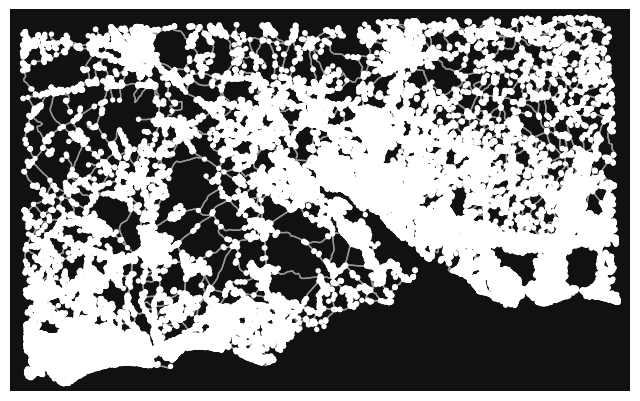

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [128]:
ox.plot_graph(drive_graph)

In [ ]:
consol_node_id = get_nearest_node(drive_graph, *consolidation_point)

In [182]:
# Create a graph that connects the consolidation point to the center of each of the features
# this graph doesn't use any coordinates, the edges represent the driving time between the
# consolidation point and the feature center

# This graph connects every feature to the consolidation point directly, no intermediate consolidation

# save the graph with name as hash of bounds and tags
consol_graph_name = f"cache/consol_graph_{hash((bounds, json.dumps(tag_list)))}.graphml"

if os.path.exists(consol_graph_name):
    consol_graph = nx.read_graphml(consol_graph_name)
else:
    consol_graph = nx.DiGraph()
    consol_graph.add_node(consol_node_id)
    for _, row in osm_features.iterrows():
        # Snap the lat/lon to the nearest node in the drive graph
        feature_node = get_nearest_node(drive_graph, *row["center"].coords[0][::-1])
        # Add the feature to the graph with attrs
        consol_graph.add_node(
            feature_node, name=row["name"], **drive_graph.nodes[feature_node]
        )
        # Find the shortest path between the consolidation point and the feature center on the drive graph
        # Travel time is used as the cost metric here, not distance
        # change to "length" to use distance
        shortest_path = ox.routing.shortest_path(
            drive_graph, consol_node_id, feature_node, weight="travel_time"
        )
        # If a path exists, add it to the graph
        if shortest_path:
            # Get metric integrals for the path
            path_travel_time = sum(
                [
                    drive_graph[shortest_path[i]][shortest_path[i + 1]][0][
                        "travel_time"
                    ]
                    for i in range(len(shortest_path) - 1)
                ]
            )
            path_distance = sum(
                [
                    drive_graph[shortest_path[i]][shortest_path[i + 1]][0]["length"]
                    for i in range(len(shortest_path) - 1)
                ]
            )
            # Add an edge to the graph
            consol_graph.add_edge(
                consol_node_id,
                feature_node,
                travel_time=path_travel_time,
                length=path_distance,
            )
            print(
                f"Added {row['name']} to the graph. Travel time: {path_travel_time}, distance: {path_distance}"
            )
    # Remove self loops
    consol_graph.remove_edges_from(nx.selfloop_edges(consol_graph))
    consol_graph.graph = drive_graph.graph
    nx.write_graphml(consol_graph, consol_graph_name)

Added Park View Surgery to the graph. Travel time: 1256.7999999999997, distance: 32218.692
Added The Old Dispensary to the graph. Travel time: 1911.6999999999991, distance: 49366.640999999996
Added Prime Medical to the graph. Travel time: 1776.6, distance: 48228.80400000002
Added Webb Peploe to the graph. Travel time: 1622.3, distance: 27388.703
Added Cornerways Medical Practice to the graph. Travel time: 1333.3000000000002, distance: 37115.243
Added St Leonards Road to the graph. Travel time: 1814.5000000000002, distance: 48986.37200000002
Added Barton Surgery to the graph. Travel time: 1859.5000000000005, distance: 36071.63599999996
Added Lifeboat Quay Medical Centre to the graph. Travel time: 2310.5999999999995, distance: 57208.03600000001
Added The Grove Surgery to the graph. Travel time: 1718.6999999999998, distance: 46200.78799999999
Added The Arnewood Practice to the graph. Travel time: 1754.2999999999995, distance: 32073.022
Added Shelley Manor & Holdenhurst Medical Centre to t

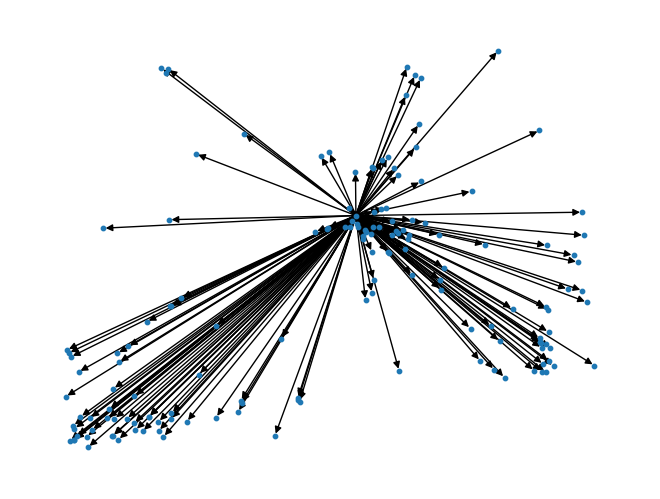

In [183]:
node_positions = {
    node: (data["lon"], data["lat"])
    for node, data in consol_graph.nodes(data=True)
}
nx.draw(consol_graph, pos=node_positions, node_size=10, )

In [186]:
ox.basic_stats(nx.MultiDiGraph(consol_graph))

{'n': 154,
 'm': 152,
 'k_avg': 1.974025974025974,
 'edge_length_total': 4468110.767999997,
 'edge_length_avg': 29395.46557894735,
 'streets_per_node_avg': 2.1948051948051948,
 'streets_per_node_counts': {0: 0, 1: 64, 2: 1, 3: 84, 4: 5},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.4155844155844156,
  2: 0.006493506493506494,
  3: 0.5454545454545454,
  4: 0.032467532467532464},
 'intersection_count': 90,
 'street_length_total': 4468110.767999997,
 'street_segment_count': 152,
 'street_length_avg': 29395.46557894735,
 'circuity_avg': 1.308409944438063,
 'self_loop_proportion': 0.0}